In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

### 1. Forecasting a Time Series
### a. Naive Forecasting Baseline:

#### Data Preparation
- Load the dataset from CSV.
- Parse the date column and rename columns for clarity.
- Sort the data by date.
- Remove redundant columns and duplicates.
- Display the first few rows.

In [2]:
data = pd.read_csv("data/ridership_data.csv", parse_dates=["service_date"])

In [3]:
data.columns = ["date", "day_type", "bus", "rail", "total"]
data = data.sort_values("date").set_index("date")
data = data.drop(columns="total")
data = data.drop_duplicates()

In [4]:
data.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


#### Data Visualization
- Plot daily ridership data for a specific time range.
- Overlay the original time series with a lagged version.
- Compute and visualize differencing to detect autocorrelation.


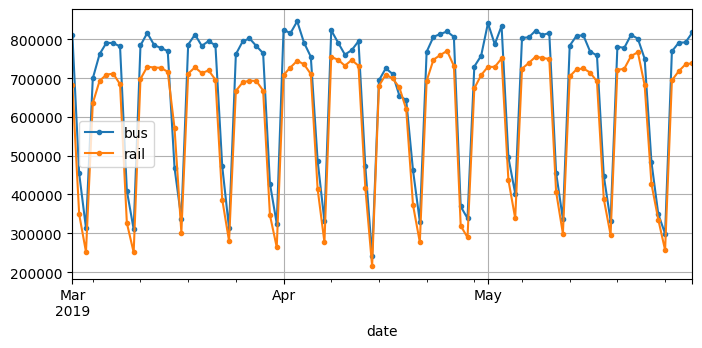

In [5]:
data.loc["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [6]:
custom_df = data.loc["2019-03": "2019-05"]

In [7]:
# diff 7 --> value at time t minus value at time t-7
diff_7 = custom_df[["bus","rail"]].diff(7)

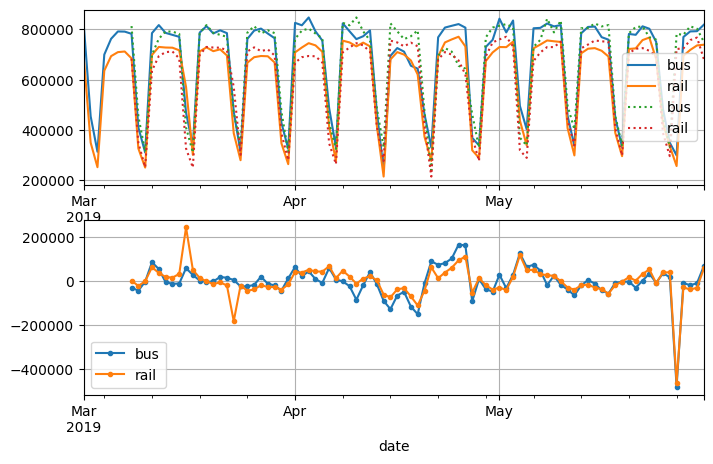

In [8]:
fig, axs = plt.subplots(2,1, figsize=(8,5))
custom_df.plot(ax=axs[0])
custom_df.shift(7).plot(ax=axs[0], linestyle=":", grid=True)
diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()


In [9]:
# auto-correlation and partial auto correlation:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

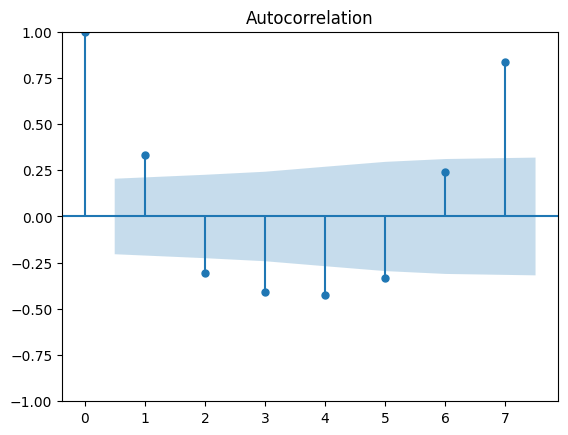

In [18]:
plot_acf(custom_df[["bus"]],lags=7);

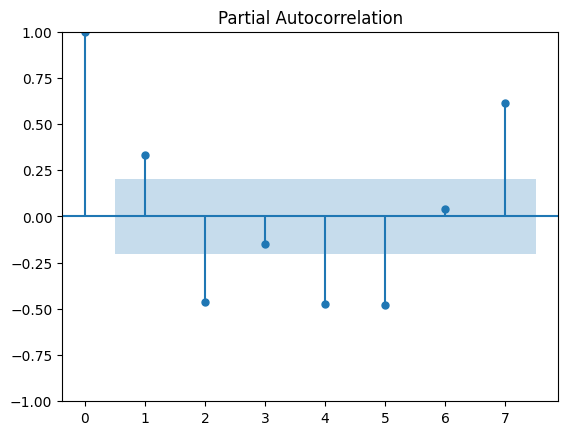

In [15]:
plot_pacf(custom_df["bus"], lags=7);

#### Naive Forecasting Baseline
- Compute the 7-day lag difference.
- Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE).

In [27]:
round((diff_7/custom_df[["bus","rail"]]).abs().mean()*100,2)

bus     8.60
rail    9.47
dtype: float64

## 2. Statistical Models for Time Series Forecasting

#### ARMA and ARIMA Modeling
- Load time series data.
- Define and fit an ARIMA model with specific hyperparameters.
- Forecast the next day's ridership.
- Evaluate the model's performance against naive forecasting.
- Perform a grid search for optimal hyperparameters.


In [29]:
?slice 

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     

In [30]:
period = slice("2001", "2019")

In [33]:
data

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2024-11-26,W,518470,356826
2024-11-27,W,477247,308919
2024-11-28,U,190991,132382


In [34]:
df_monthly = data[["bus", "rail"]].resample("M").mean()

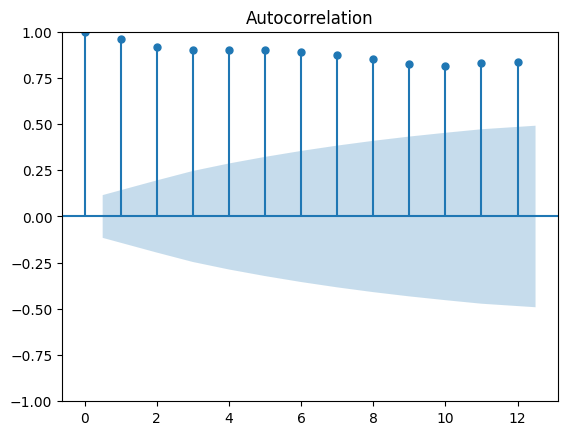

In [38]:
plot_acf(df_monthly["bus"], lags=12);

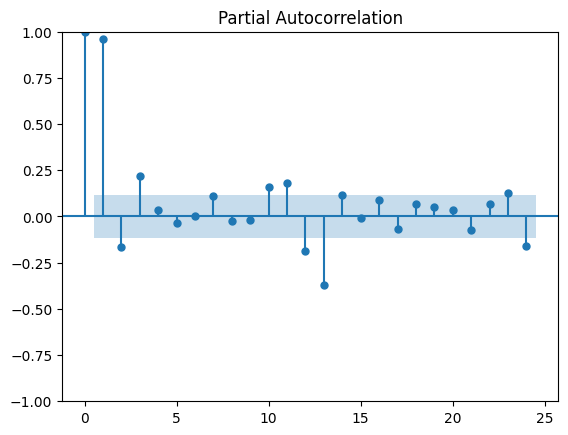

In [41]:
plot_pacf(df_monthly["rail"], lags=24);

In [44]:
rolling_12 = df_monthly[period].rolling(window=12).mean()


<Axes: xlabel='date'>

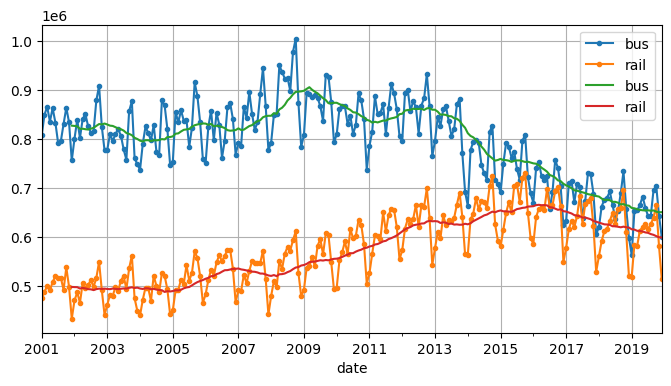

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_12.plot(ax=ax, grid=True)

<Axes: xlabel='date'>

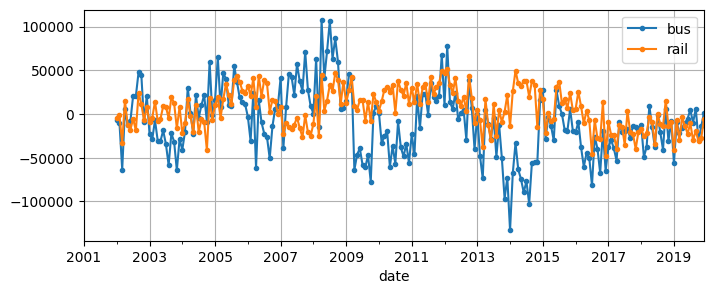

In [49]:
# 12 month difference:
df_monthly[period].diff(12).plot(marker=".", grid=True, figsize=(8,3))

In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [53]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = data.loc[origin:today]["rail"].asfreq("D")

In [55]:
rail_series.head()

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
Freq: D, Name: rail, dtype: int64

In [61]:
# order=(p,d,q)
# seasonal_order = (P, D, Q, s)

In [70]:
model = ARIMA(rail_series,order=(1,0,0),seasonal_order=(0,1,1,7))
model = model.fit()

In [71]:
y_pred = model.forecast()
y_pred

2019-06-01    427758.626222
Freq: D, dtype: float64

In [62]:
# run the same code in a loop to make
# forecasts for every day in March, April, and May, and compute the MAE
# over that period:

In [64]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
# time_period

In [66]:
rail_series = data.loc[origin:end_date]["rail"].asfreq("D")
rail_series.head()

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
Freq: D, Name: rail, dtype: int64

In [76]:
y_preds = []
for i in time_period.shift(-1):
    model = ARIMA(rail_series[origin:i], order=(1,0,0), seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

In [77]:
y_preds = pd.Series(y_preds, index=time_period)

In [83]:
mae = ((y_preds - rail_series[time_period])/rail_series[time_period]).abs().mean()
mae * 100

7.54310072810324